# Employee Attrition Prediction

Based on the employees survey questions, predictiing whether the employee has any intentions to leave the company or not. Checking their satisfactions.


# **STEP 1: Creating a Normalized Database (3NF) using SQLITE**

In [1]:
#Installing all the required libraries.
import numpy as np
import pandas as pd
import sqlite3

#import matplotlib.pyplot as plt
import seaborn as sns
import bokeh as bk

from scipy import stats
from statsmodels.stats import weightstats as stests
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Use a non-interactive backend
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score,roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
#Now creating a normalized 3nf database using employee attrition data.

# Now loading the dataset into the database by creating a 3nf tables.
file_path = "C:/Users/anchu/ML_Project_Python/datasets/employee_attrition.csv"
employee_attrition_data = pd.read_csv(file_path)

# Establish a connection to SQLite and create a database
connection = sqlite3.connect("employee_attrition.db")
cursor = connection.cursor() #Now creating a cursor using a connection that is established.

# Now creating the tables based on the similarities of the columns.
cursor.execute("""
CREATE TABLE IF NOT EXISTS Education (
    EducationFieldID INTEGER PRIMARY KEY AUTOINCREMENT,
    EducationField TEXT NOT NULL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS MaritalStatus (
    MaritalStatusID INTEGER PRIMARY KEY AUTOINCREMENT,
    MaritalStatus TEXT NOT NULL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Job (
    JobRoleID INTEGER PRIMARY KEY AUTOINCREMENT,
    JobRole TEXT NOT NULL,
    Department TEXT NOT NULL,
    JobLevel INTEGER NOT NULL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Employee (
    EmployeeID INTEGER PRIMARY KEY,
    Age INTEGER NOT NULL,
    Gender TEXT NOT NULL,
    DistanceFromHome INTEGER NOT NULL,
    EducationFieldID INTEGER NOT NULL,
    MaritalStatusID INTEGER NOT NULL,
    JobRoleID INTEGER NOT NULL,
    FOREIGN KEY (EducationFieldID) REFERENCES Education(EducationFieldID),
    FOREIGN KEY (MaritalStatusID) REFERENCES MaritalStatus(MaritalStatusID),
    FOREIGN KEY (JobRoleID) REFERENCES Job(JobRoleID)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS EmployeeMetrics (
    MetricID INTEGER PRIMARY KEY AUTOINCREMENT,
    EmployeeID INTEGER NOT NULL,
    EnvironmentSatisfaction INTEGER NOT NULL,
    JobSatisfaction INTEGER NOT NULL,
    WorkLifeBalance INTEGER NOT NULL,
    StockOptionLevel INTEGER NOT NULL,
    TotalWorkingYears INTEGER NOT NULL,
    YearsAtCompany INTEGER NOT NULL,
    YearsInCurrentRole INTEGER NOT NULL,
    NumCompaniesWorked INTEGER NOT NULL,
    PercentSalaryHike INTEGER NOT NULL,
    DailyRate REAL NOT NULL,
    MonthlyIncome REAL NOT NULL,
    FOREIGN KEY (EmployeeID) REFERENCES Employee(EmployeeID)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Attrition (
    AttritionID INTEGER PRIMARY KEY AUTOINCREMENT,
    EmployeeID INTEGER NOT NULL,
    Attrition TEXT NOT NULL,
    FOREIGN KEY (EmployeeID) REFERENCES Employee(EmployeeID)
);
""")

# Insert unique values into lookup tables
education_fields = employee_attrition_data['EducationField'].unique()
marital_statuses = employee_attrition_data['MaritalStatus'].unique()
job_roles = employee_attrition_data[['JobRole', 'Department', 'JobLevel']].drop_duplicates()

cursor.executemany("INSERT INTO Education (EducationField) VALUES (?);", [(field,) for field in education_fields])
cursor.executemany("INSERT INTO MaritalStatus (MaritalStatus) VALUES (?);", [(status,) for status in marital_statuses])
cursor.executemany(
    "INSERT INTO Job (JobRole, Department, JobLevel) VALUES (?, ?, ?);",
    job_roles.values.tolist()
)

# Commit the changes
connection.commit()

# Map lookup table IDs to the main dataset
education_mapping = {row[1]: row[0] for row in cursor.execute("SELECT * FROM Education").fetchall()}
marital_status_mapping = {row[1]: row[0] for row in cursor.execute("SELECT * FROM MaritalStatus").fetchall()}
job_mapping = {
    (row[1], row[2], row[3]): row[0]
    for row in cursor.execute("SELECT * FROM Job").fetchall()
}

# Prepare data for Employee table
employee_data = [
    (
        row['EmployeeNumber'],
        row['Age'],
        row['Gender'],
        row['DistanceFromHome'],
        education_mapping[row['EducationField']],
        marital_status_mapping[row['MaritalStatus']],
        job_mapping[(row['JobRole'], row['Department'], row['JobLevel'])]
    )
    for _, row in employee_attrition_data.iterrows()
]

cursor.executemany(
    "INSERT INTO Employee (EmployeeID, Age, Gender, DistanceFromHome, EducationFieldID, MaritalStatusID, JobRoleID) VALUES (?, ?, ?, ?, ?, ?, ?);",
    employee_data
)

# Prepare data for EmployeeMetrics table
employee_metrics_data = [
    (
        row['EmployeeNumber'],
        row['EnvironmentSatisfaction'],
        row['JobSatisfaction'],
        row['WorkLifeBalance'],
        row['StockOptionLevel'],
        row['TotalWorkingYears'],
        row['YearsAtCompany'],
        row['YearsInCurrentRole'],
        row['NumCompaniesWorked'],
        row['PercentSalaryHike'],
        row['DailyRate'],
        row['MonthlyIncome']
    )
    for _, row in employee_attrition_data.iterrows()
]

cursor.executemany(
    "INSERT INTO EmployeeMetrics (EmployeeID, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, StockOptionLevel, TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, NumCompaniesWorked, PercentSalaryHike, DailyRate, MonthlyIncome) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);",
    employee_metrics_data
)

# Prepare data for Attrition table
attrition_data = [
    (row['EmployeeNumber'], row['Attrition'])
    for _, row in employee_attrition_data.iterrows()
]

cursor.executemany(
    "INSERT INTO Attrition (EmployeeID, Attrition) VALUES (?, ?);",
    attrition_data
)

# Commit all changes
connection.commit()
print("Database populated successfully.")

# Close the connection
connection.close()


IntegrityError: UNIQUE constraint failed: Employee.EmployeeID

In [3]:
#Now the process is to develop the code to push all the data inside the multiple tables into the pandas dataframe.

#Now establishing the connection again by connecting it to the database file.
conn_data = sqlite3.connect("employee_attrition.db")

#Now implementing a query to to fetch data into the dataframe.

query = """
SELECT 
    e.EmployeeID,
    e.Age,
    e.Gender,
    e.DistanceFromHome,
    ed.EducationField,
    ms.MaritalStatus,
    j.JobRole,
    j.Department,
    j.JobLevel,
    em.EnvironmentSatisfaction,
    em.JobSatisfaction,
    em.WorkLifeBalance,
    em.StockOptionLevel,
    em.TotalWorkingYears,
    em.YearsAtCompany,
    em.YearsInCurrentRole,
    em.NumCompaniesWorked,
    em.PercentSalaryHike,
    em.DailyRate,
    em.MonthlyIncome,
    a.Attrition
FROM Employee e
JOIN Education ed ON e.EducationFieldID = ed.EducationFieldID
JOIN MaritalStatus ms ON e.MaritalStatusID = ms.MaritalStatusID
JOIN Job j ON e.JobRoleID = j.JobRoleID
JOIN EmployeeMetrics em ON e.EmployeeID = em.EmployeeID
JOIN Attrition a ON e.EmployeeID = a.EmployeeID;
"""

data = pd.read_sql_query(query, conn_data)

conn_data.close()

data.head()

,EmployeeID,Age,Gender,DistanceFromHome,EducationField,MaritalStatus,JobRole,Department,JobLevel,EnvironmentSatisfaction,...,WorkLifeBalance,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,NumCompaniesWorked,PercentSalaryHike,DailyRate,MonthlyIncome,Attrition
0,1,41,Female,1,Life Sciences,Single,Sales Executive,Sales,2,2,...,1,0,8,6,4,8,11,1102.0,5993.0,Yes
1,2,49,Male,8,Life Sciences,Married,Research Scientist,Research & Development,2,3,...,3,1,10,10,7,1,23,279.0,5130.0,No
2,4,37,Male,2,Other,Single,Laboratory Technician,Research & Development,1,4,...,3,0,7,0,0,6,15,1373.0,2090.0,Yes
3,5,33,Female,3,Life Sciences,Married,Research Scientist,Research & Development,1,4,...,3,0,8,8,7,1,11,1392.0,2909.0,No
4,7,27,Male,2,Medical,Married,Laboratory Technician,Research & Development,1,1,...,3,1,6,2,2,9,12,591.0,3468.0,No


# **STEP 2: Exploring the data, train test split**

**Now the process is to explore through the data and find out if the data needs to be stratified or not. After the process the data needs to be splitted into train and test sets**


The count of attritions are No     1233
Yes     237
Name: Attrition, dtype: int64


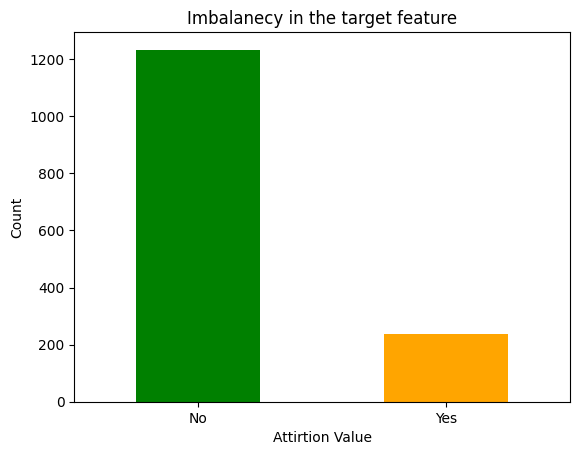

In [4]:
#Now checking for balency in the dataset for target feature
Attrition_count = data['Attrition'].value_counts()
print('The count of attritions are', Attrition_count) #by looking at the below outputs it tells that, the data is not balanced. So, the data needs to be stratified.

Attrition_count.plot(kind='bar', color = ['green', 'orange'])
plt.title("Imbalanecy in the target feature")
plt.xlabel('Attirtion Value')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.show()

In [5]:
#Since the data is imbalanced, this can be done using train and test split

#Now dividing the data into x and y features, where y contains target outcome.
x = data.drop(['Attrition', 'EmployeeID'], axis=1)
y = data['Attrition']

#Now after dividing the data, it will now further be divided into train and test split.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, stratify= y, random_state=55)

#Now thus verifying the stratification to ensure the data is split equally.
print("Training set stratification")
print(y_train.value_counts())

print("The testing set stratification")
print(y_test.value_counts())

Training set stratification
No     986
Yes    190
Name: Attrition, dtype: int64
The testing set stratification
No     247
Yes     47
Name: Attrition, dtype: int64


# **STEP 3: Exploring the data and performing analysis**

**Exploring using yprofile and performing co-relation matrix, performing cleaning, making observations, converting data columns into numerical ones.**

In [6]:
#Checking for datatypes and column names present in the dataset.
print(data.dtypes)

print(data.columns)

#now checking for null values inside the dataset.
print(data.isnull().sum())

EmployeeID                   int64
Age                          int64
Gender                      object
DistanceFromHome             int64
EducationField              object
MaritalStatus               object
JobRole                     object
Department                  object
JobLevel                     int64
EnvironmentSatisfaction      int64
JobSatisfaction              int64
WorkLifeBalance              int64
StockOptionLevel             int64
TotalWorkingYears            int64
YearsAtCompany               int64
YearsInCurrentRole           int64
NumCompaniesWorked           int64
PercentSalaryHike            int64
DailyRate                  float64
MonthlyIncome              float64
Attrition                   object
dtype: object
Index(['EmployeeID', 'Age', 'Gender', 'DistanceFromHome', 'EducationField',
       'MaritalStatus', 'JobRole', 'Department', 'JobLevel',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'StockOptionLevel', 'TotalWorkingYe

In [7]:
#Now removing the unwanted employee id which is of no use.
data.drop(columns='EmployeeID', axis = 1, inplace= True)

In [8]:
data.head()

,Age,Gender,DistanceFromHome,EducationField,MaritalStatus,JobRole,Department,JobLevel,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,NumCompaniesWorked,PercentSalaryHike,DailyRate,MonthlyIncome,Attrition
0,41,Female,1,Life Sciences,Single,Sales Executive,Sales,2,2,4,1,0,8,6,4,8,11,1102.0,5993.0,Yes
1,49,Male,8,Life Sciences,Married,Research Scientist,Research & Development,2,3,2,3,1,10,10,7,1,23,279.0,5130.0,No
2,37,Male,2,Other,Single,Laboratory Technician,Research & Development,1,4,3,3,0,7,0,0,6,15,1373.0,2090.0,Yes
3,33,Female,3,Life Sciences,Married,Research Scientist,Research & Development,1,4,3,3,0,8,8,7,1,11,1392.0,2909.0,No
4,27,Male,2,Medical,Married,Laboratory Technician,Research & Development,1,1,2,3,1,6,2,2,9,12,591.0,3468.0,No


**Performing visualizations to get deeper insights about numerical, continous, nominal, and ordinal data.**

In [9]:
continous=['Age','DailyRate','MonthlyIncome','PercentSalaryHike','Attrition'] #continous data column names
nominal=['Department','EducationField','Gender','JobRole','Attrition']#nominal data column names
ordinal=['EnvironmentSatisfaction','JobLevel','JobSatisfaction',
         'WorkLifeBalance','Attrition'] #ordinal data column names
other_cols= ['StockOptionLevel','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','Attrition']


data_continous=pd.DataFrame()
data_continous=data.loc[:,['Age','DailyRate','MonthlyIncome','PercentSalaryHike','Attrition']] #extracting all the continous data




data_nominal=pd.DataFrame()
data_nominal=data.loc[:,['Department','EducationField','Gender','JobRole','Attrition']] # extracting all nominal data


data_ordinal=pd.DataFrame()
data_ordinal=data.loc[:,['EnvironmentSatisfaction','JobLevel','JobSatisfaction',
                        'WorkLifeBalance','Attrition']] #extracting all ordinal data


data_other_cols=pd.DataFrame()
data_other_cols = data.loc[:,['StockOptionLevel','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','Attrition']]

In [10]:
#Now exploring data through continous data
data_continous.describe()

,Age,DailyRate,MonthlyIncome,PercentSalaryHike
count,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,6502.931293,15.209524
std,9.135373,403.509100,4707.956783,3.659938
min,18.000000,102.000000,1009.000000,11.000000
25%,30.000000,465.000000,2911.000000,12.000000
50%,36.000000,802.000000,4919.000000,14.000000
75%,43.000000,1157.000000,8379.000000,18.000000
max,60.000000,1499.000000,19999.000000,25.000000


Now performing analysis for nominal data too to check for discrepencies.

<Figure size 2500x1500 with 0 Axes>

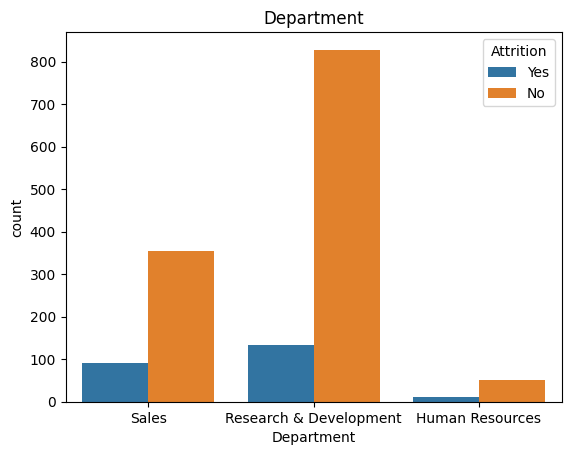

<Figure size 2500x1500 with 0 Axes>

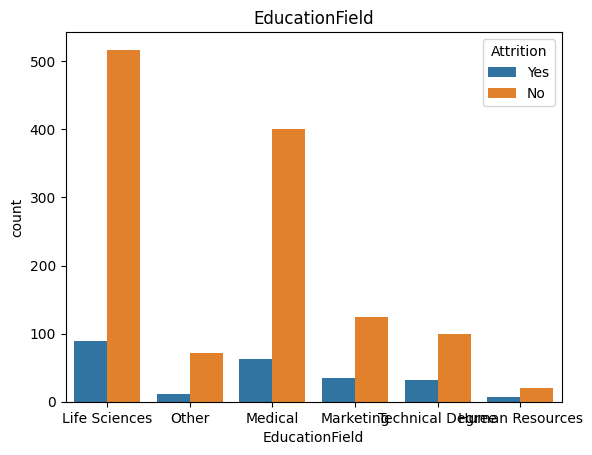

<Figure size 2500x1500 with 0 Axes>

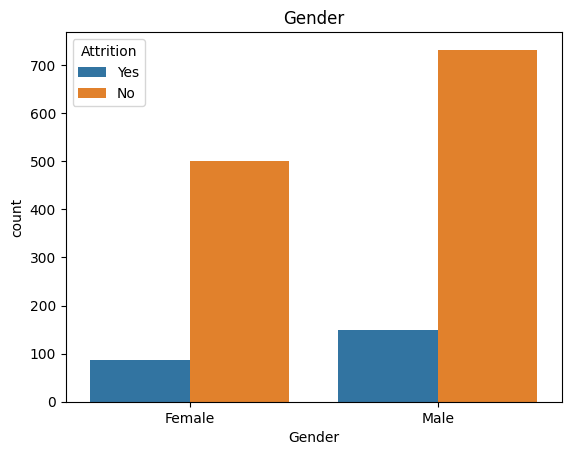

<Figure size 2500x1500 with 0 Axes>

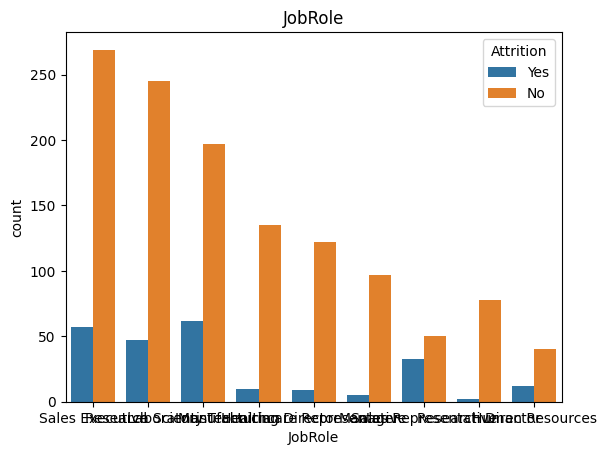

In [11]:
#performing co-relations among the several datasets
nominal1=['Department','EducationField','Gender','JobRole']
for i in nominal1:
    plt.figure(figsize=(25,15))
    plt.figure(i)
    sns.countplot(x=data_nominal[i],hue=data_nominal['Attrition'])
    plt.title(i)
    plt.show()

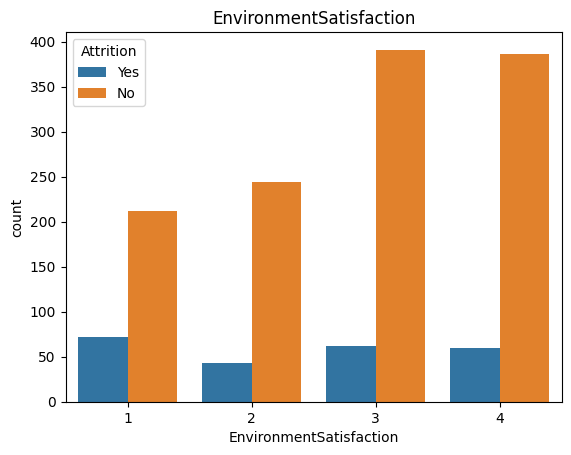

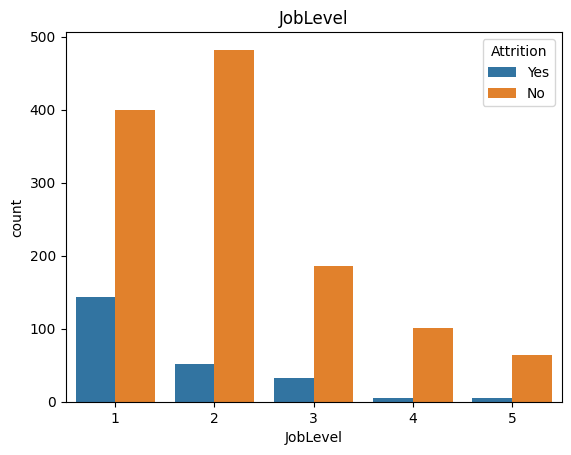

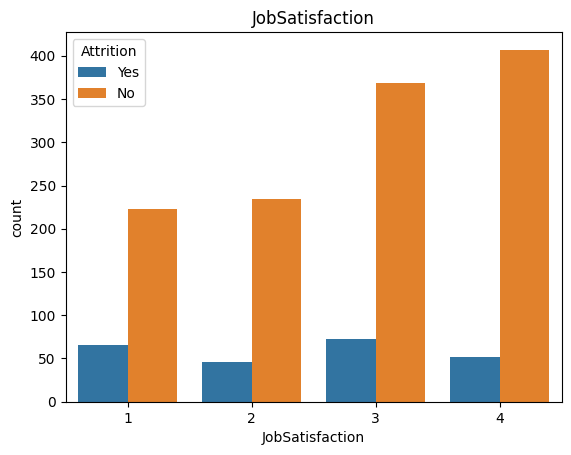

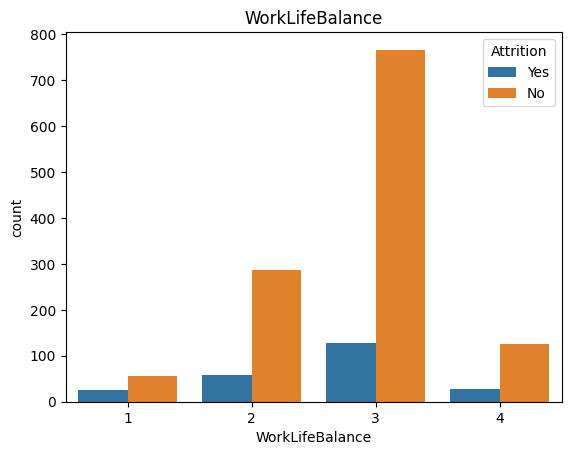

In [12]:
#Now performing analysis for ordinal data to check for in-depth analysis and discrepencies.
ordinal1=['EnvironmentSatisfaction','JobLevel','JobSatisfaction',
         'WorkLifeBalance']


for i in ordinal1:
    plt.figure(i)
    sns.countplot(x=data_ordinal[i],hue=data_ordinal['Attrition'])
    plt.title(i)

**Now performing co-relation between all the ordinal, nominal, continous columns and the other type of columns**

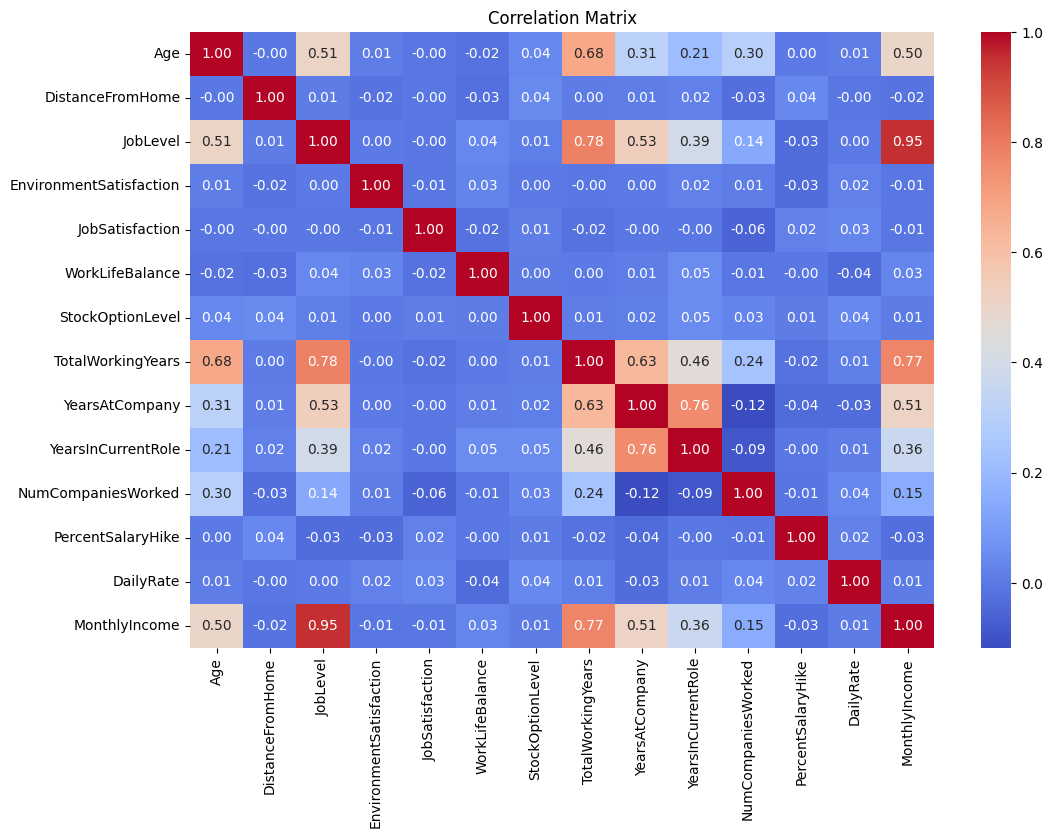

               Age  DistanceFromHome     JobLevel  EnvironmentSatisfaction  \
count  1470.000000       1470.000000  1470.000000              1470.000000   
mean     36.923810          9.192517     2.063946                 2.721769   
std       9.135373          8.106864     1.106940                 1.093082   
min      18.000000          1.000000     1.000000                 1.000000   
25%      30.000000          2.000000     1.000000                 2.000000   
50%      36.000000          7.000000     2.000000                 3.000000   
75%      43.000000         14.000000     3.000000                 4.000000   
max      60.000000         29.000000     5.000000                 4.000000   

       JobSatisfaction  WorkLifeBalance  StockOptionLevel  TotalWorkingYears  \
count      1470.000000      1470.000000       1470.000000        1470.000000   
mean          2.728571         2.761224          0.793878          11.279592   
std           1.102846         0.706476          0.852077

In [13]:
# Compute correlation matrix
correlation_matrix = data.corr(numeric_only=True)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Check for capped distributions (e.g., Age, YearsAtCompany)
print(data.describe())

#Feature Relationships:
# Analyze correlations for highly correlated features
high_corr_features = correlation_matrix[
    (correlation_matrix > 0.8) & (correlation_matrix < 1.0)
].stack()
print("Highly Correlated Features:")
print(high_corr_features)

In [14]:
#From above all these analysis, it is identified that YearsAtCompany column and value of max_income will have to be reduced to below 17000.
data = data[data['MonthlyIncome'] < 17000]
data.drop(['YearsAtCompany', 'JobLevel'], axis = 1, inplace = True)
data.head()


,Age,Gender,DistanceFromHome,EducationField,MaritalStatus,JobRole,Department,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,StockOptionLevel,TotalWorkingYears,YearsInCurrentRole,NumCompaniesWorked,PercentSalaryHike,DailyRate,MonthlyIncome,Attrition
0,41,Female,1,Life Sciences,Single,Sales Executive,Sales,2,4,1,0,8,4,8,11,1102.0,5993.0,Yes
1,49,Male,8,Life Sciences,Married,Research Scientist,Research & Development,3,2,3,1,10,7,1,23,279.0,5130.0,No
2,37,Male,2,Other,Single,Laboratory Technician,Research & Development,4,3,3,0,7,0,6,15,1373.0,2090.0,Yes
3,33,Female,3,Life Sciences,Married,Research Scientist,Research & Development,4,3,3,0,8,7,1,11,1392.0,2909.0,No
4,27,Male,2,Medical,Married,Laboratory Technician,Research & Development,1,2,3,1,6,2,9,12,591.0,3468.0,No


In [15]:
#converting Nominal categorical data into numerical data
data['MaritalStatus'].replace(['Single','Married','Divorced'],[1,2,3],inplace=True)
data['Department'].replace(['Sales','Research & Development','Human Resources'],[1,2,3],inplace=True)
data['EducationField'].replace(['Life Sciences','Medical','Other','Marketing','Technical Degree','Human Resources'],[1,2,3,4,5,6],inplace=True)
data['Gender'].replace(['Male','Female'],[1,2],inplace=True)
data['JobRole'].replace(['Sales Executive','Research Scientist',
                         'Laboratory Technician','Manufacturing Director',
                         'Healthcare Representative','Manager',
                         'Sales Representative','Research Director','Human Resources'],[1,2,3,4,5,6,7,8,9],inplace=True)
data['Attrition'].replace(['Yes','No'],[0,1],inplace=True)

In [16]:
data

,Age,Gender,DistanceFromHome,EducationField,MaritalStatus,JobRole,Department,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,StockOptionLevel,TotalWorkingYears,YearsInCurrentRole,NumCompaniesWorked,PercentSalaryHike,DailyRate,MonthlyIncome,Attrition
0,41,2,1,1,1,1,1,2,4,1,0,8,4,8,11,1102.0,5993.0,0
1,49,1,8,1,2,2,2,3,2,3,1,10,7,1,23,279.0,5130.0,1
2,37,1,2,3,1,3,2,4,3,3,0,7,0,6,15,1373.0,2090.0,0
3,33,2,3,1,2,2,2,4,3,3,0,8,7,1,11,1392.0,2909.0,1
4,27,1,2,2,2,3,2,1,2,3,1,6,2,9,12,591.0,3468.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,23,2,2,3,2,3,4,3,1,17,2,4,17,884.0,2571.0,1
1466,39,1,6,2,2,5,2,4,1,3,1,9,7,4,15,613.0,9991.0,1
1467,27,1,4,1,2,4,2,2,2,3,1,6,2,1,20,155.0,6142.0,1
1468,49,1,2,2,2,1,1,4,2,2,0,17,6,2,14,1023.0,5390.0,1


# **EXPERIMENT 1 Creating a pre-processing for scaling and predicting**

In [17]:
import pandas as pd
import sqlite3
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import mlflow
import mlflow.sklearn

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

# Split features and target
x = data.drop(columns=["Attrition"])
y = data["Attrition"]

# Define preprocessing pipeline (only for numerical scaling)
numerical_features = x.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p, validate=True))
        ]), numerical_features)
    ]
)

# Define the full pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Cross-validation and hyperparameter tuning
cv_results = cross_validate(
    pipeline, x, y, cv=3,
    scoring={
        "f1": "f1",
        "precision": "precision",
        "recall": "recall",
        "accuracy": "accuracy"
    },
    return_train_score=True
)

# Log results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition prediction experiment 1")

with mlflow.start_run():
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("scaler", "StandardScaler + MinMaxScaler + LogTransformation")
    mlflow.log_param("cross_validation", "3-fold")
    
    mean_f1 = np.mean(cv_results["test_f1"])
    std_f1 = np.std(cv_results["test_f1"])
    
    mlflow.log_metric("mean_f1", mean_f1)
    mlflow.log_metric("std_f1", std_f1)
    
    # Log model
    mlflow.sklearn.log_model(pipeline, "model")

# Output results
print("Cross-validation results (3-fold):")
for key, values in cv_results.items():
    print(f"{key}: {values}")
print("\nMean F1-score:", mean_f1)
print("Standard deviation of F1-score:", std_f1)

# Confusion matrix on training data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


2024/12/20 15:10:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run masked-conch-451 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/0/runs/2d975dc7eb9d48f2acd9697ad2aacc91
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/0
Cross-validation results (3-fold):
fit_time: [0.06682897 0.0456543  0.027596  ]
score_time: [0.01643944 0.         0.01614046]
test_f1: [0.91346154 0.91172914 0.91575092]
train_f1: [0.91325301 0.91494532 0.91404358]
test_precision: [0.84070796 0.84529148 0.85421412]
train_precision: [0.84315907 0.84988713 0.84736251]
test_recall: [1.         0.98950131 0.98684211]
train_recall: [0.99605782 0.99078947 0.99211564]
test_accuracy: [0.84279476 0.84061135 0.84901532]
train_accuracy: [0.84262295 0.84699454 0.84497817]

Mean F1-score: 0.9136471985625553
Standard deviation of F1-score: 0.0016471226094842523

Confusion Matrix:
[[  4  41]
 [  2 228]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.

# **EXPERIMENT 2: Preprocessing and Using Multiple Algorithms**

Experiment #2: Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier, RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.

In [18]:
import pandas as pd
import sqlite3
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import mlflow
import mlflow.sklearn

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p, validate=True))
        ]), numerical_features)
    ]
)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Perform cross-validation and log results
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition prediction experiment 2")

for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])

    cv_results = cross_validate(
        pipeline, x, y, cv=2,
        scoring={
            "f1": "f1",
            "precision": "precision",
            "recall": "recall",
            "accuracy": "accuracy"
        },
        return_train_score=True
    )

    with mlflow.start_run():
        mlflow.log_param("model", name)
        mlflow.log_param("scaler", "StandardScaler + MinMaxScaler + LogTransformation")
        mlflow.log_param("cross_validation", "3-fold")
        
        mean_f1 = np.mean(cv_results["test_f1"])
        std_f1 = np.std(cv_results["test_f1"])
        
        mlflow.log_metric("mean_f1", mean_f1)
        mlflow.log_metric("std_f1", std_f1)
        mlflow.log_metric("mean_accuracy", np.mean(cv_results["test_accuracy"]))
        mlflow.log_metric("mean_precision", np.mean(cv_results["test_precision"]))
        mlflow.log_metric("mean_recall", np.mean(cv_results["test_recall"]))
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")

    print(f"Results for {name}:")
    print("Mean F1-score:", mean_f1)
    print("Standard deviation of F1-score:", std_f1)
    print("\n")


2024/12/20 15:10:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run blushing-flea-328 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1/runs/7bc1498f1da449b7980e2a4dd2587df6
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1
Results for LogisticRegression:
Mean F1-score: 0.9136471985625553
Standard deviation of F1-score: 0.0016471226094842523




2024/12/20 15:11:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run luminous-steed-693 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1/runs/1681d53271ee4552b3376821cadedbb2
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1
Results for RidgeClassifier:
Mean F1-score: 0.9094658916480345
Standard deviation of F1-score: 0.0019728771578128115




2024/12/20 15:11:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run defiant-jay-554 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1/runs/b2d7ef184cd84bb9b8cfe398ee728f33
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1
Results for RandomForestClassifier:
Mean F1-score: 0.9084945872945712
Standard deviation of F1-score: 0.0021806661637977943




2024/12/20 15:11:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run debonair-penguin-787 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1/runs/a7333b077bef4e39a7a65938bafdabad
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/1
Results for XGBClassifier:
Mean F1-score: 0.9010448559617918
Standard deviation of F1-score: 0.0016848415597721963




# **Experiment 3: feature engineering and attribute combination.**

Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.

In [19]:
import pandas as pd
import sqlite3
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import mlflow
import mlflow.sklearn

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

# Feature engineering: Create new features
data["IncomePerYearWorked"] = data["MonthlyIncome"] / (data["TotalWorkingYears"] + 1)
data["SatisfactionIndex"] = (
    data["EnvironmentSatisfaction"] + data["JobSatisfaction"] + data["WorkLifeBalance"]
) / 3

# Split features and target
x_ex = data.drop(columns=["Attrition"])
y_ex = data["Attrition"]

# Define preprocessing pipeline (only for numerical scaling)
numerical_features = x_ex.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p, validate=True))
        ]), numerical_features)
    ]
)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Perform cross-validation and log results
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition Prediction Experiment 3")

for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])

    cv_results = cross_validate(
        pipeline, x_ex, y_ex, cv=3,
        scoring={
            "f1": "f1",
            "precision": "precision",
            "recall": "recall",
            "accuracy": "accuracy"
        },
        return_train_score=True
    )

    with mlflow.start_run():
        mlflow.log_param("model", name)
        mlflow.log_param("scaler", "StandardScaler + MinMaxScaler + LogTransformation")
        mlflow.log_param("cross_validation", "3-fold")
        
        mean_f1 = np.mean(cv_results["test_f1"])
        std_f1 = np.std(cv_results["test_f1"])
        
        mlflow.log_metric("mean_f1", mean_f1)
        mlflow.log_metric("std_f1", std_f1)
        mlflow.log_metric("mean_accuracy", np.mean(cv_results["test_accuracy"]))
        mlflow.log_metric("mean_precision", np.mean(cv_results["test_precision"]))
        mlflow.log_metric("mean_recall", np.mean(cv_results["test_recall"]))
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")

    print(f"Results for {name}:")
    print("Mean F1-score:", mean_f1)
    print("Standard deviation of F1-score:", std_f1)
    print("\n")


2024/12/20 15:12:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run vaunted-squirrel-805 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2/runs/4d656f57127b44b8a2bf3ea190312722
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2
Results for LogisticRegression:
Mean F1-score: 0.9143815385631453
Standard deviation of F1-score: 0.0011979853926774562




2024/12/20 15:12:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sedate-newt-491 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2/runs/7a168fbe71c34c7e96575a8314ef1482
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2
Results for RidgeClassifier:
Mean F1-score: 0.9106254604997465
Standard deviation of F1-score: 0.0011741480335745644




2024/12/20 15:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run stylish-snail-753 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2/runs/3ea7bc96488743e7a606630e5315f1af
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2
Results for RandomForestClassifier:
Mean F1-score: 0.9120387165947553
Standard deviation of F1-score: 0.0011050572584650358




2024/12/20 15:13:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run vaunted-auk-305 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2/runs/31e5993bdf204b57918a396776a5cc6e
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/2
Results for XGBClassifier:
Mean F1-score: 0.9056187030636776
Standard deviation of F1-score: 0.00613905084023977




# **EXPERIMENT 4: Feature Selection, Feature Importance, Variance Threshold**

Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold. Log results in MLFlow.

In [20]:
import pandas as pd
import sqlite3
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import mlflow
import mlflow.sklearn

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

# Feature Selection: Variance Threshold
variance_selector = VarianceThreshold(threshold=0.1)
X_var = variance_selector.fit_transform(x)
selected_features_var = x.columns[variance_selector.get_support()]

# Feature Selection: Correlation Threshold
correlation_matrix = pd.DataFrame(x).corr()
high_corr_pairs = correlation_matrix.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > 0.8]
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs.to_csv("high_correlation_features.csv", index = False)

# Feature Selection: SelectKBest
select_k_best = SelectKBest(score_func=f_classif, k=10)
X_kbest = select_k_best.fit_transform(x, y)
selected_features_kbest = x.columns[select_k_best.get_support()]

# Log selected features in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition Prediction Experiment 4")

with mlflow.start_run():
    mlflow.log_param("feature_selection_method", "Variance, Correlation, SelectKBest")
    mlflow.log_param("variance_threshold", list(selected_features_var))
    mlflow.log_param("k_best_features", list(selected_features_kbest))
    mlflow.log_metric("num_variance_selected_features", len(selected_features_var))
    mlflow.log_metric("num_k_best_features", len(selected_features_kbest))
    mlflow.log_artifact("high_correlation_features.csv")  # Log correlation pairs if needed

    print("Variance Threshold Selected Features:")
    print(selected_features_var)
    print("\nSelectKBest Features:")
    print(selected_features_kbest)


Variance Threshold Selected Features:
Index(['Age', 'Gender', 'DistanceFromHome', 'EducationField', 'MaritalStatus',
       'JobRole', 'Department', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'StockOptionLevel', 'TotalWorkingYears',
       'YearsInCurrentRole', 'NumCompaniesWorked', 'PercentSalaryHike',
       'DailyRate', 'MonthlyIncome'],
      dtype='object')

SelectKBest Features:
Index(['Age', 'DistanceFromHome', 'EducationField', 'MaritalStatus',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'YearsInCurrentRole', 'MonthlyIncome'],
      dtype='object')
🏃 View run nimble-bass-362 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/3/runs/c9828074baa14755b9281f8422cb4cb2
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/3


# **EXPERIMENT 5: Applying PCA**

Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. Log results in MLFlow.

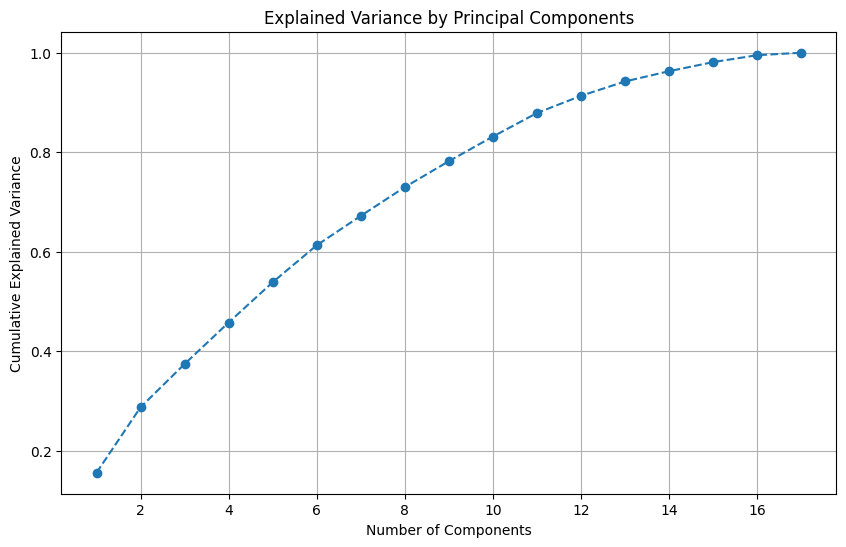

Number of components to retain: 14
Explained Variance Ratio:
[0.15573991 0.13161896 0.08688641 0.08340954 0.08091522 0.0742552
 0.05912626 0.05781413 0.05208112 0.049508   0.04737032 0.03454581
 0.02891146 0.02060526 0.01827814 0.01389751 0.00503675]

Number of Components to Retain: 14
🏃 View run unleashed-hawk-298 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/5/runs/73cca7e094b04053a1a5dc879cdfa7da
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/5


In [21]:
import pandas as pd
import sqlite3
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.sklearn

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

# Preprocessing pipeline
numerical_features = x.select_dtypes(include=["int64", "float64"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p, validate=True))
        ]), numerical_features)
    ]
)

# Apply PCA
pca = PCA()
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", pca)
])

# Fit PCA to the data
X_pca = pipeline.fit_transform(x)
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Determine the number of components to retain
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Retain components explaining 95% variance
print(f"Number of components to retain: {n_components}")

# Log results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition Prediction Experiment #5")

with mlflow.start_run():
    mlflow.log_param("dimensionality_reduction", "PCA")
    for i, variance in enumerate(explained_variance, start=1):
        mlflow.log_metric(f"explained_variance_ratio_component_{i}", variance)
    mlflow.log_metric("cumulative_variance_95_components", n_components)

    print("Explained Variance Ratio:")
    print(explained_variance)
    print("\nNumber of Components to Retain:", n_components)


# **EXPERIMENT 6: Creating a custom experiment**

**In this custom experiment, I have implemented decision tree**

In [22]:
from sklearn.metrics import f1_score

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

# Feature engineering: Custom engineered features
data["IncomePerYearWorked"] = data["MonthlyIncome"] / (data["TotalWorkingYears"] + 1)
data["SatisfactionIndex"] = (
    data["EnvironmentSatisfaction"] + data["JobSatisfaction"] + data["WorkLifeBalance"]
) / 3

# Split features and target
x_ex6 = data.drop(columns=["Attrition"])
y_ex6 = data["Attrition"]

# Preprocessing pipeline
numerical_features = x_ex6.select_dtypes(include=["int64", "float64"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p, validate=True))
        ]), numerical_features)
    ]
)

# Custom Experiment: Combine Logistic Regression with Feature Scaling and Custom Features
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42, max_features=10))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_ex6, y_ex6, test_size=0.2, random_state=42)

# Fit and evaluate the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Log results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition Prediction Experiment 6")

with mlflow.start_run():
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("scaling", "StandardScaler + MinMaxScaler + LogTransformation")
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("accuracy", accuracy)

    print("Custom Experiment Results:")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")


Custom Experiment Results:
F1 Score: 0.8269662921348315
Precision: 0.8558139534883721
Recall: 0.8
Accuracy: 0.72
🏃 View run capable-fish-816 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/6/runs/126fa1a9daea41a69c4f12d05d0402da
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/6


# **EXPERIMENT 7: Another custom experiment**

**In this custom experiment I'm using KNN classifier**

In [23]:
from sklearn.metrics import f1_score

# Set DagsHub credentials (replace with your username and token)
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "lakshmisruthi2113"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "fb625b8241fcd55ee2e320bfd8b24df629a66cec"

# Feature engineering: Custom engineered features
data["IncomePerYearWorked"] = data["MonthlyIncome"] / (data["TotalWorkingYears"] + 1)
data["SatisfactionIndex"] = (
    data["EnvironmentSatisfaction"] + data["JobSatisfaction"] + data["WorkLifeBalance"]
) / 3

# Split features and target
x_ex6 = data.drop(columns=["Attrition"])
y_ex6 = data["Attrition"]

# Preprocessing pipeline
numerical_features = x_ex6.select_dtypes(include=["int64", "float64"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p, validate=True))
        ]), numerical_features)
    ]
)

# Custom Experiment: Combine Logistic Regression with Feature Scaling and Custom Features
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=10, n_jobs=5, leaf_size=3))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_ex6, y_ex6, test_size=0.2, random_state=42)

# Fit and evaluate the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Log results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow")  # Replace with your DagsHub credentials
mlflow.set_experiment("Attrition Prediction Experiment 7")

with mlflow.start_run():
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("scaling", "StandardScaler + MinMaxScaler + LogTransformation")
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("accuracy", accuracy)

    print("Custom Experiment Results:")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")


Custom Experiment Results:
F1 Score: 0.9101796407185629
Precision: 0.8413284132841329
Recall: 0.991304347826087
Accuracy: 0.8363636363636363
🏃 View run hilarious-bee-252 at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/7/runs/97cf380262034a5d9926e684c7850e63
🧪 View experiment at: https://dagshub.com/lakshmisruthi2113/my-first-repo.mlflow/#/experiments/7


# **STEP 8: F1 Scores of all models**

Writing out of all f1 scores of every models, and comparing which one is performing better.

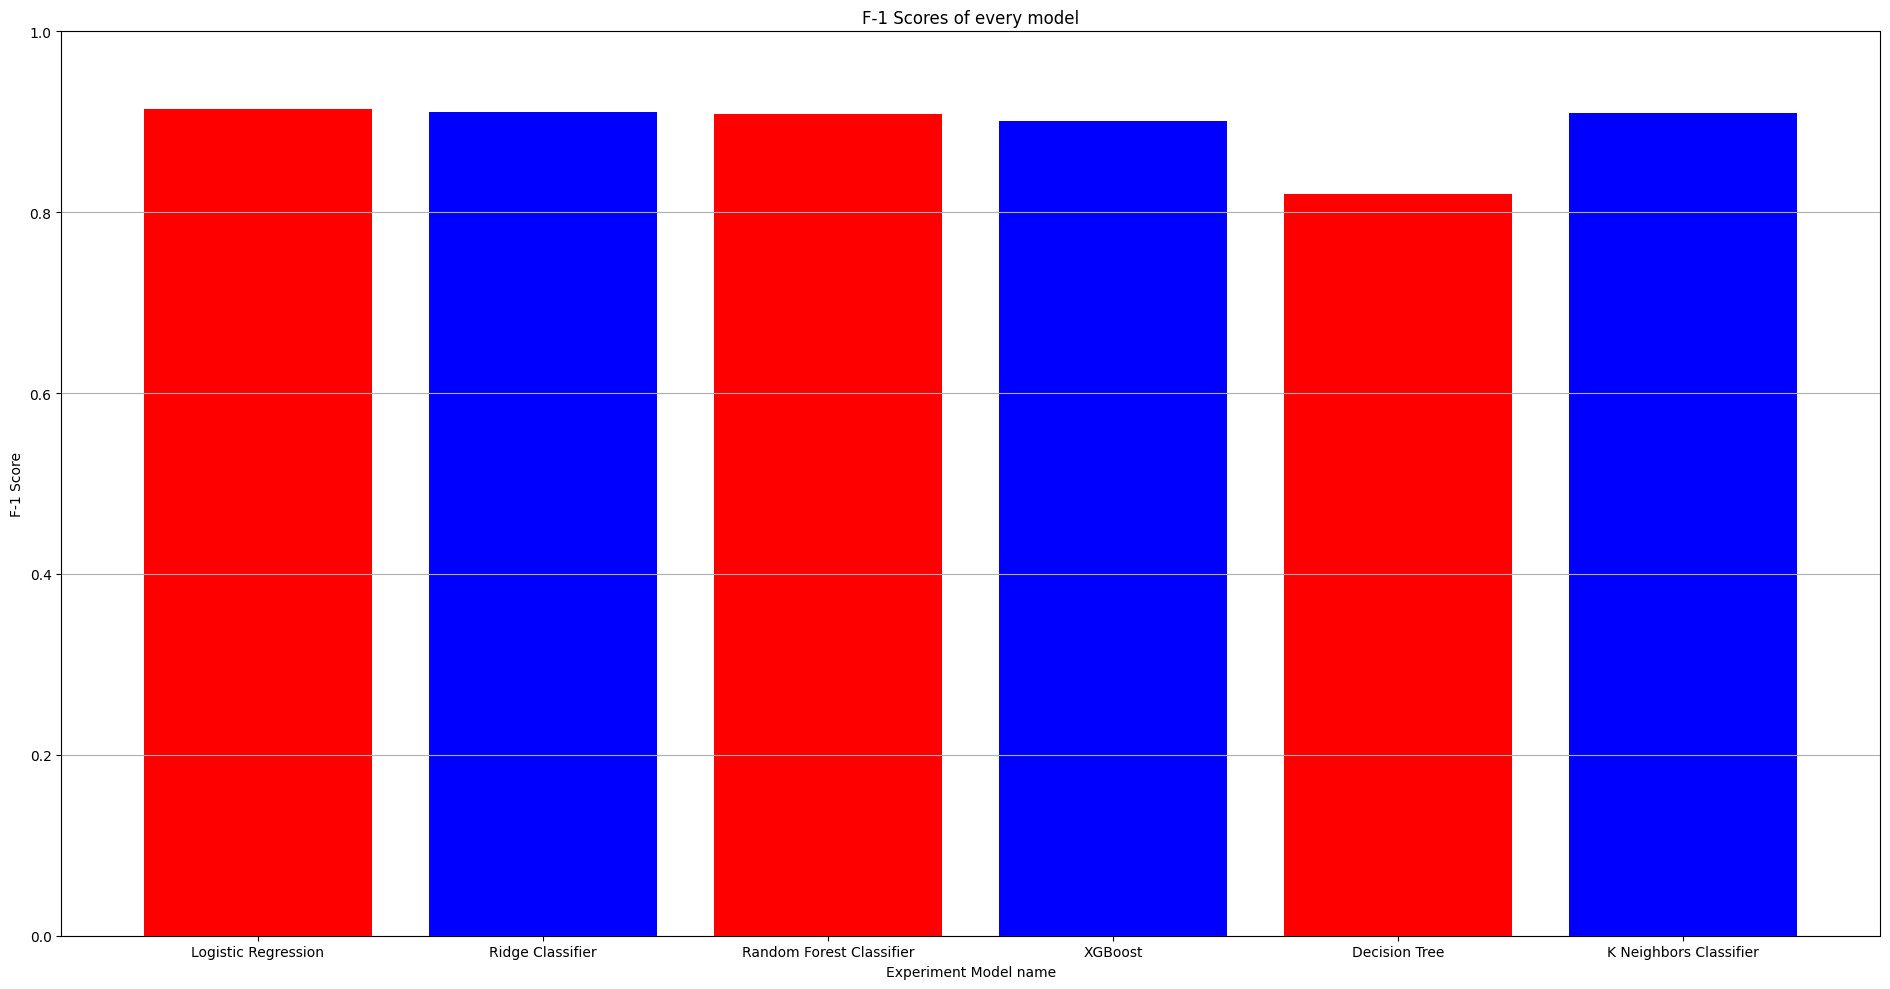

In [24]:
f1_scores_exp = {
    "Logistic Regression": 0.9143,
    "Ridge Classifier": 0.9106,
    "Random Forest Classifier": 0.9084,
    "XGBoost": 0.9010,
    "Decision Tree": 0.82,
    "K Neighbors Classifier": 0.91
}

plt.figure(figsize = (19,10))
plt.bar(f1_scores_exp.keys(), f1_scores_exp.values(), color = ['red', 'blue'])
plt.title('F-1 Scores of every model')
plt.xlabel('Experiment Model name')
plt.ylabel('F-1 Score')
plt.ylim(0,1)
plt.grid(axis = 'y')
plt.tight_layout()
plt.show()

#Based on the analysis, logistic regression and K Neigbors classfier are best overall performing models among all others.

# **Step 9: Creation of FastAPI for model and Streamlit APP**

Now saving the model using joblib and that model will serve as predictions whether the employee is willing to leave the company or not. Also, a streamlit app is created in order to make predictions directly in the webpage with the new unseen data.

In [26]:
data

,Age,Gender,DistanceFromHome,EducationField,MaritalStatus,JobRole,Department,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,StockOptionLevel,TotalWorkingYears,YearsInCurrentRole,NumCompaniesWorked,PercentSalaryHike,DailyRate,MonthlyIncome,Attrition,IncomePerYearWorked,SatisfactionIndex
0,41,2,1,1,1,1,1,2,4,1,0,8,4,8,11,1102.0,5993.0,0,665.888889,2.333333
1,49,1,8,1,2,2,2,3,2,3,1,10,7,1,23,279.0,5130.0,1,466.363636,2.666667
2,37,1,2,3,1,3,2,4,3,3,0,7,0,6,15,1373.0,2090.0,0,261.250000,3.333333
3,33,2,3,1,2,2,2,4,3,3,0,8,7,1,11,1392.0,2909.0,1,323.222222,3.333333
4,27,1,2,2,2,3,2,1,2,3,1,6,2,9,12,591.0,3468.0,1,495.428571,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,23,2,2,3,2,3,4,3,1,17,2,4,17,884.0,2571.0,1,142.833333,3.333333
1466,39,1,6,2,2,5,2,4,1,3,1,9,7,4,15,613.0,9991.0,1,999.100000,2.666667
1467,27,1,4,1,2,4,2,2,2,3,1,6,2,1,20,155.0,6142.0,1,877.428571,2.333333
1468,49,1,2,2,2,1,1,4,2,2,0,17,6,2,14,1023.0,5390.0,1,299.444444,2.666667


In [31]:
#Before creating a streamlit app, data is retrieved.
data.drop(columns=["Unnamed: 0", "IncomePerYearWorked", "SatisfactionIndex"], errors = 'ignore', inplace = True)
data.to_csv('data_final.csv')

In [36]:
%%writefile app.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Load the dataset
data = pd.read_csv("C:/Users/anchu/ML_Project_Python/datasets/data_final.csv", index_col=0)

# Drop unnecessary columns
columns_to_drop = ["IncomePerYearWorked", "SatisfactionIndex"]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Split features and target
x_final = data.drop(columns=["Attrition"], errors='ignore')
y_final = data["Attrition"]

# Identify numerical and categorical features
numerical_features = x_final.select_dtypes(include=["int64", "float64"]).columns

# Safe log transformation
def safe_log_transform(X):
    return np.log1p(np.maximum(X, 0))

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(safe_log_transform, validate=True))
        ]), numerical_features)
    ]
)

# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_jobs=10, n_neighbors=5, metric='minkowski'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Save the model using joblib
joblib.dump(pipeline, "attrition_model.joblib")

# FastAPI application
from fastapi import FastAPI

app = FastAPI()

# Load the model
model = joblib.load("attrition_model.joblib")

@app.post("/predict")
async def predict(input_data: dict):
    """Endpoint to make predictions."""
    input_df = pd.DataFrame([input_data])

    # Convert categorical fields to numeric manually
    input_df["Gender"] = input_df["Gender"].map({"Male": 0, "Female": 1})
    input_df["EducationField"] = input_df["EducationField"].map({"Life Sciences": 0, "Medical": 1, "Marketing": 2, "Technical Degree": 3, "Other": 4})
    input_df["MaritalStatus"] = input_df["MaritalStatus"].map({"Single": 0, "Married": 1, "Divorced": 2})
    input_df["JobRole"] = input_df["JobRole"].map({"Sales Executive": 0, "Research Scientist": 1, "Laboratory Technician": 2, "Manager": 3, "Sales Representative": 4, "Research Director": 5, "Human Resources": 6, "Healthcare Representative": 7, "Manufacturing Director": 8})
    input_df["Department"] = input_df["Department"].map({"Sales": 0, "Research & Development": 1, "Human Resources": 2})

    # Validate input data
    input_df = input_df.replace([np.inf, -np.inf], np.nan).fillna(0)

    processed_input = model.named_steps['preprocessor'].transform(input_df)
    prediction = model.named_steps['classifier'].predict(processed_input)
    return {"prediction": int(prediction[0])}

##########################################
# Streamlit App
import streamlit as st

st.title("Employee Attrition Prediction")

st.write("Provide the following details to predict employee attrition:")

# Input fields
input_data = {
    "Age": st.number_input("Age", min_value=18, max_value=70, step=1),
    "Gender": st.selectbox("Gender", ["Male", "Female"]),
    "DistanceFromHome": st.number_input("Distance From Home", min_value=0, max_value=100, step=1),
    "EducationField": st.selectbox("Education Field", ["Life Sciences", "Medical", "Marketing", "Technical Degree", "Other"]),
    "MaritalStatus": st.selectbox("Marital Status", ["Single", "Married", "Divorced"]),
    "JobRole": st.selectbox("Job Role", ["Sales Executive", "Research Scientist", "Laboratory Technician", "Manager", "Sales Representative", "Research Director", "Human Resources", "Healthcare Representative", "Manufacturing Director"]),
    "Department": st.selectbox("Department", ["Sales", "Research & Development", "Human Resources"]),
    "JobLevel": st.number_input("Job Level", min_value=1, max_value=5, step=1),
    "EnvironmentSatisfaction": st.number_input("Environment Satisfaction", min_value=1, max_value=4, step=1),
    "JobSatisfaction": st.number_input("Job Satisfaction", min_value=1, max_value=4, step=1),
    "WorkLifeBalance": st.number_input("Work Life Balance", min_value=1, max_value=4, step=1),
    "StockOptionLevel": st.number_input("Stock Option Level", min_value=0, max_value=3, step=1),
    "TotalWorkingYears": st.number_input("Total Working Years", min_value=0, max_value=50, step=1),
    "YearsInCurrentRole": st.number_input("Years in Current Role", min_value=0, max_value=30, step=1),
    "NumCompaniesWorked": st.number_input("Number of Companies Worked", min_value=0, max_value=15, step=1),
    "PercentSalaryHike": st.number_input("Percent Salary Hike", min_value=0, max_value=100, step=1),
    "DailyRate": st.number_input("Daily Rate", min_value=0, max_value=2000, step=1),
    "MonthlyIncome": st.number_input("Monthly Income", min_value=0, max_value=50000, step=100),
}

if st.button("Predict Attrition"):
    input_df = pd.DataFrame([input_data])

    # Convert categorical fields to numeric manually
    input_df["Gender"] = input_df["Gender"].map({"Male": 0, "Female": 1})
    input_df["EducationField"] = input_df["EducationField"].map({"Life Sciences": 0, "Medical": 1, "Marketing": 2, "Technical Degree": 3, "Other": 4})
    input_df["MaritalStatus"] = input_df["MaritalStatus"].map({"Single": 0, "Married": 1, "Divorced": 2})
    input_df["JobRole"] = input_df["JobRole"].map({"Sales Executive": 0, "Research Scientist": 1, "Laboratory Technician": 2, "Manager": 3, "Sales Representative": 4, "Research Director": 5, "Human Resources": 6, "Healthcare Representative": 7, "Manufacturing Director": 8})
    input_df["Department"] = input_df["Department"].map({"Sales": 0, "Research & Development": 1, "Human Resources": 2})

    # Validate input data
    input_df = input_df.replace([np.inf, -np.inf], np.nan).fillna(0)

    processed_input = model.named_steps['preprocessor'].transform(input_df)
    prediction = model.named_steps['classifier'].predict(processed_input)
    st.write("Prediction: ", "Employee is not willing to leave the company." if prediction[0] == 1 else "Employee is likely to leave.")




Overwriting app.py
